# LSTM and GRU Models
(Core)

*Christina Brockway*

Using the "spooky" dataset from: 
https://drive.google.com/file/d/1uUtuiAM1AqGvDMrd3-L8vLFfHPrt3pWG/view?usp=sharing
This dataset represents passages from three famous authors: Edgar Allan Poe, HP Lovecraft, and Mary Shelley.

### Starting with the Text Vecorization Notebook

In [1]:
## Imports

import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

%load_ext autoreload
%autoreload 2
import my_functions as mf


In [2]:
df=pd.read_csv("data/spooky.csv", index_col='id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [3]:
#Length of each test
df['length'] = df['text'].map(lambda x:  len(x.split(" ")))
df.head(1)

,text,author,length
id,,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP,41


In [4]:
df['length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: length, dtype: float64

In [5]:
df['author'].value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [6]:
#Use random undersampler
sampler= RandomUnderSampler(random_state=42)
df, _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()


EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [7]:
## Create a map for targets
target_map = {'EAP':0, 'HPL':1, 'MWS':2}
y=df['author'].map(target_map)
y.value_counts(normalize=True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [8]:
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [9]:
# Define X 
X=df['text'].values

In [10]:
#Convert dataset to object
ds = tf.data.Dataset.from_tensor_slices((X, y))

ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
#Shuffle dataset
ds= ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [12]:
#Train/Val/Test Split

# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)

# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)

# Test size is remainder
split_test = 1 - (split_train + split_val)
n_test_samples = len(ds)-(n_train_samples+n_val_samples)

BATCH_SIZE=32

import math
train_batch = math.ceil(n_train_samples/BATCH_SIZE)
val_batch = math.ceil(n_val_samples/BATCH_SIZE)
test_batch = math.ceil(n_test_samples/BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {n_train_samples} samples as training data, {train_batch} training batches.')
print (f' TThere are {n_val_samples} samples as validation data, {val_batch} training batches.')
print (f' There are {n_test_samples} samples as testing data, {test_batch} training batches.')

 There are 11833 samples as training data, 370 training batches.
 TThere are 3381 samples as validation data, 106 training batches.
 There are 1691 samples as testing data, 53 training batches.


In [13]:
## use the "take" and "skip" methods to make the splits.

# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
val_ds = val_ds.take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [14]:
SEQ_LENGTH = 100
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation', output_mode='int',
    output_sequence_length=SEQ_LENGTH)

In [15]:
#Obtain the text from the training dataset using a lambda function
ds_text = train_ds.map(lambda x,y:x)

In [16]:
## Train (adapt) the vectorization layer on the text data
sequence_vectorizer.adapt(ds_text)
sequence_vectorizer.vocabulary_size()

20976

In [17]:
# Check the size of the vocabulary
VOCAB_SIZE = len(sequence_vectorizer.get_vocabulary())
VOCAB_SIZE

20976

In [18]:
# Get list of vocabulary words
vocabulary = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocabulary)}

### LSTM

**Define a function to build and compile a simple LSTM model**
    -  
Use the pre-trained text vectorization layer from the practice assignmen
    -  
Create an embedding layer with output_dim =1
    -  0
Add an LSTM layer with 128 un
    -  ts
Add an appropriate output l
    -  yer
Compile the model with the adam optimizer, loss = "sparse_categorical_corssentropy" and metrics = "accu
    -  acy"
Include an early stopping callback with a patienc
-  Build, Fit, and Evaluate the modele of 3

In [19]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(sequence_vectorizer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=150, 
                                  input_length=SEQ_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [20]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [21]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 44s 115ms/step - loss: 1.1155 - accuracy: 0.3317 - val_los

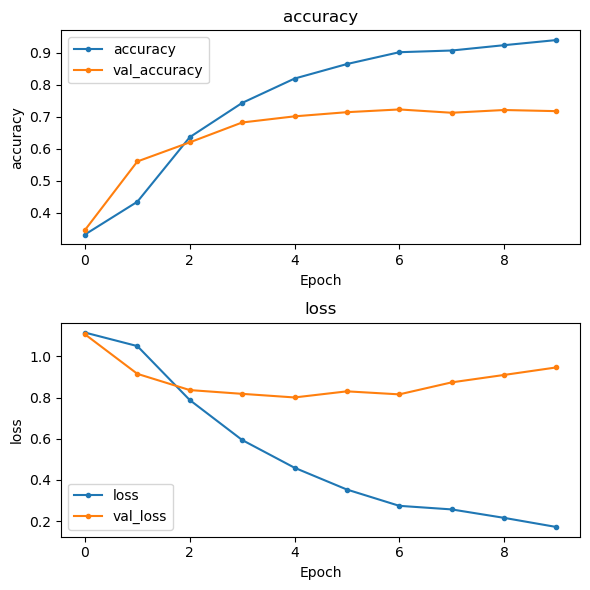


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3906
           1       0.99      0.96      0.97      3952
           2       0.96      0.96      0.96      3975

    accuracy                           0.96     11833
   macro avg       0.96      0.96      0.96     11833
weighted avg       0.96      0.96      0.96     11833



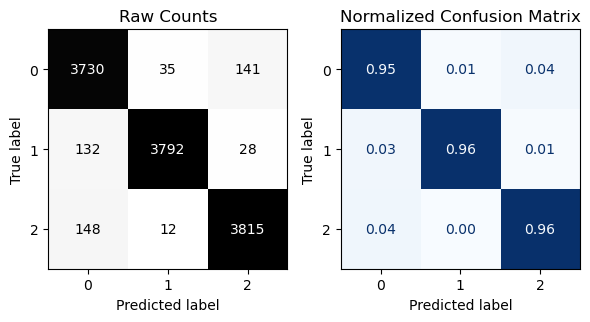


- Evaluating Training Data:
370/370 [==============================] - 10s 28ms/step - loss: 0.1216 - accuracy: 0.9581
{'loss': 0.12159186601638794, 'accuracy': 0.9580833315849304}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       559
           1       0.77      0.74      0.75       560
           2       0.79      0.74      0.77       572

    accuracy                           0.72      1691
   macro avg       0.73      0.72      0.72      1691
weighted avg       0.73      0.72      0.72      1691



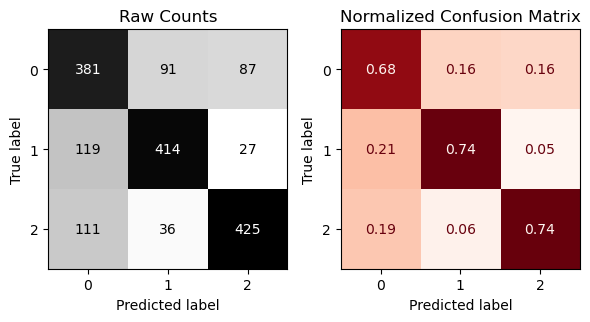


- Evaluating Test Data:
53/53 [==============================] - 1s 26ms/step - loss: 0.9589 - accuracy: 0.7215
{'loss': 0.9588861465454102, 'accuracy': 0.721466600894928}


In [22]:

    
# Obtain the results
results = mf.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

### GRU

-  Define a function to build and compile a simple GRU model-  
Follow the same steps as above, but instead of an LSTM layer, use a GRU laye
-  
Build, Fit, and Evaluate the model

In [23]:
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(sequence_vectorizer):
                
    gru_model = Sequential([
        sequence_vectorizer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=150, 
                                  input_length=SEQ_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [24]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

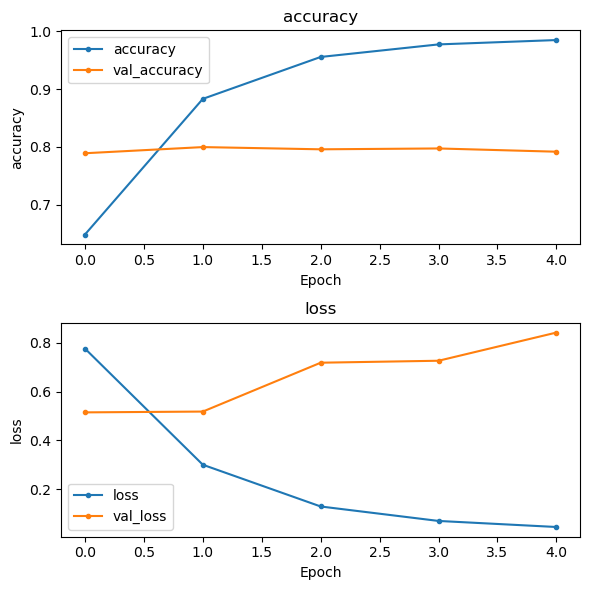


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3906
           1       1.00      0.99      1.00      3952
           2       0.99      0.99      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



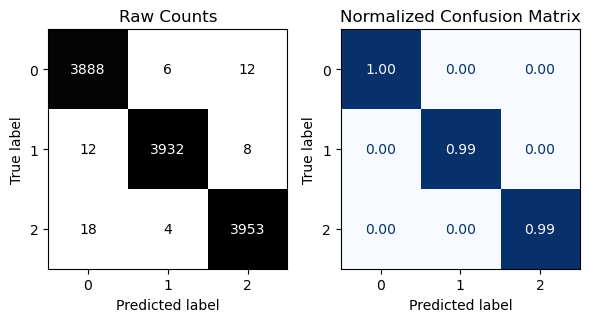


- Evaluating Training Data:
370/370 [==============================] - 8s 21ms/step - loss: 0.0192 - accuracy: 0.9949
{'loss': 0.01919516921043396, 'accuracy': 0.9949294328689575}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       559
           1       0.84      0.80      0.82       560
           2       0.82      0.84      0.83       572

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



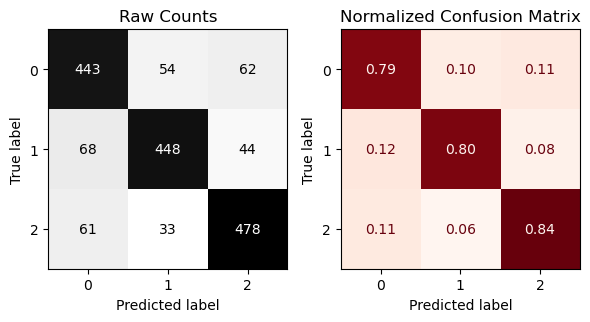


- Evaluating Test Data:
53/53 [==============================] - 1s 22ms/step - loss: 0.7800 - accuracy: 0.8096
{'loss': 0.7799688577651978, 'accuracy': 0.8095801472663879}


In [26]:
#Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = mf.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);